-21866.90682238832
True


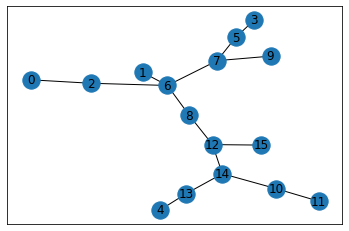

In [9]:
import numpy as np
import copy
import networkx as nx

def loadfile(filename1, filename2=None):
    ds1 = np.loadtxt("small-10-datasets/nltcs.ts.data", delimiter=",", dtype=int)
    if filename2:
        ds2 = np.loadtxt("small-10-datasets/nltcs.valid.data", delimiter=",", dtype=int)
        ds = np.vstack((ds1, ds2))
    else:
        ds = ds1
    return ds, ds.shape[0], ds.shape[1]

def prob_matrix(ds, m, n):
    prob_xy = np.zeros((n, n, 4))
    for i in range(n):
        subds = ds[ds[:, i] == 0]
        for j in range(n):
            if prob_xy[i, j, 0] == 0:
                prob_xy[i, j, 0] = (subds[subds[:, j] == 0].shape[0]+1)/(m+4)
            if prob_xy[j, i, 0] == 0:
                prob_xy[j, i, 0] = prob_xy[i, j, 0]
            if prob_xy[i, j, 1] == 0:
                prob_xy[i, j, 1] = (subds[subds[:, j] == 1].shape[0]+1)/(m+4)
            if prob_xy[j, i, 2] == 0:
                prob_xy[j, i, 2] = prob_xy[i, j, 1]
            
        subds = ds[ds[:, i] == 1]
        for j in range(n):
            if prob_xy[i, j, 2] == 0:
                prob_xy[i, j, 2] = (subds[subds[:, j] == 0].shape[0]+1)/(m+4)
            if prob_xy[j, i, 1] == 0:
                prob_xy[j, i, 1] = prob_xy[i, j, 2]
            if prob_xy[i, j, 3] == 0:
                prob_xy[i, j, 3] = (subds[subds[:, j] == 1].shape[0]+1)/(m+4)
            if prob_xy[j, i, 3] == 0:
                prob_xy[j, i, 3] = prob_xy[i, j, 3]
    return prob_xy

def edge_weights(prob_xy, n):
    edge_wts = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i < j:
                edge_wts[i, j] = prob_xy[i, j, 0]*np.log(prob_xy[i, j, 0]/(prob_xy[i, i, 0]*prob_xy[j, j, 0])) \
                + prob_xy[i, j, 1]*np.log(prob_xy[i, j, 1]/(prob_xy[i, i, 0]*prob_xy[j, j, 3])) \
                + prob_xy[i, j, 2]*np.log(prob_xy[i, j, 2]/(prob_xy[i, i, 3]*prob_xy[j, j, 0])) \
                + prob_xy[i, j, 3]*np.log(prob_xy[i, j, 3]/(prob_xy[i, i, 3]*prob_xy[j, j, 3]))
    return edge_wts

def draw_tree(edge_wts, prnt = False):
    edge_wts_cp = copy.deepcopy(edge_wts)
    edges = [np.unravel_index(np.argmax(edge_wts_cp), edge_wts_cp.shape)]
    visited = [[edges[-1][0],edges[-1][1]]]
    edge_wts_cp[edges[-1]] = 0
    while(len(edges) < n-1):
        i = j = -1
        edge = np.unravel_index(np.argmax(edge_wts_cp), edge_wts_cp.shape)
        for bag in range(len(visited)):
            if edge[0] in visited[bag]:
                i = bag
            if edge[1] in visited[bag]:
                j = bag
        if i == -1 and j != -1:
            #print("Visited", visited)
            #print("Added", edge)
            edges.append(edge)
            visited[j].append(edge[0])
        elif i != -1 and j == -1:
            #print("Visited", visited)
            #print("Added", edge)
            edges.append(edge)
            visited[i].append(edge[1])
        elif i == -1 and j == -1:
            #print("Visited", visited)
            #print("Added", edge)
            edges.append(edge)
            visited.append([edge[0], edge[1]])
        elif i != -1 and j != -1 and i != j:
            #print("Visited", visited)
            #print("Added", edge)
            edges.append(edge)
            visited[i] += visited[j]
            visited.remove(visited[j])
        elif i == j != -1:
            pass
            #print("Discarded", edge)
        else:
            #pass
            print("Discarded in else", edge)
        edge_wts_cp[edge] = 0
    #print(edges)
    #print(visited)
    
    if prnt:
        G = nx.Graph()
        G.add_nodes_from(visited[0])
        G.add_edges_from(edges)
        nx.draw_networkx(G, with_labels=True, arrows=True)
    
    return edges

def count_matrix(ds, tree, cols):
    count_xy = np.zeros((len(tree), cols))
    for idx, node in enumerate(tree):
        i, j = node
        count_xy[idx] = [ds[(ds[:, i]==0) & (ds[:, j]==0)].shape[0], ds[(ds[:, i]==0) & (ds[:, j]==1)].shape[0], ds[(ds[:, i]==1) & (ds[:, j]==0)].shape[0], ds[(ds[:, i]==1) & (ds[:, j]==1)].shape[0]]
    #print(count_xy)
    return count_xy

if __name__ == "__main__":
    ds, m, n = loadfile("small-10-datasets/nltcs.ts.data", "small-10-datasets/nltcs.valid.data")    
    prob_xy = prob_matrix(ds, m, n)
    edge_wts = edge_weights(prob_xy, n)
    
    tree = draw_tree(edge_wts, True)
    
    tree = [(8,6), (6,1), (6,7), (6,2), (2,0), (7,9), (7,5), (5,3), (8,12), (12,15), (12,14), (14,13), (13,4), (14,10), (10,11)]
    tree = [(tree[0][0], tree[0][0])] + tree

    cond_prob = np.zeros((len(tree), prob_xy.shape[2]))
    for idx, node in enumerate(tree):
        if node[0] == node[1]:
            cond_prob[idx] = np.log(prob_xy[node[0], node[1],:])
        else:
            cond_prob[idx] = np.log(np.hstack(((prob_xy[node[0], node[1],:2]/prob_xy[node[0], node[0], 0]),(prob_xy[node[0], node[1],2:]/prob_xy[node[0], node[0], 3]))))
    #print((cond_prob))
    ts = np.loadtxt("small-10-datasets/nltcs.test.data", delimiter=",", dtype=int)

    count_xy = count_matrix(ts, tree, prob_xy.shape[2])

    print(np.sum(count_xy*cond_prob))

    print(edge_wts[np.unravel_index(np.argmax(edge_wts), edge_wts.shape)] == edge_wts.max())

In [ ]:
-21866.90682238832
-22227.175018301103

In [45]:
#For checking correctness of probs
for i in range(prob_xy.shape[0]):
    for j in range(prob_xy.shape[1]):
        for k in range(prob_xy.shape[2]):
            if k == 0:
                subds = ds[(ds[:, i]==0) & (ds[:, j]==0)]
            elif k == 1:
                subds = ds[(ds[:, i]==0) & (ds[:, j]==1)]
            elif k == 2:
                subds = ds[(ds[:, i]==1) & (ds[:, j]==0)]
            elif k == 3:
                subds = ds[(ds[:, i]==1) & (ds[:, j]==1)]
            if prob_xy[i, j, k] != (subds.shape[0]+1)/(m+4):
                print(" prob_xy["+i+", "+j+", "+k+"] != (subds.shape[0]+1)/(m+4)")
            else:
                print(" prob_xy["+str(i)+", "+str(j)+", "+str(k)+"] == (subds.shape[0]+1)/(m+4)")

5.4519681605059426e-05
